The dataset is from Kaggle for hatespeech detection. The dataset used for training the model is the balanced one which has equal proportions of class labels. 

Dataset Link: https://www.kaggle.com/datasets/waalbannyantudre/hate-speech-detection-curated-dataset?select=HateSpeechDatasetBalanced.csv

In [ ]:
#Importing the necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
from sklearn.pipeline import Pipeline

In [ ]:
#Importing the dataset
df = pd.read_csv("Datasets/HateSpeechDatasetBalanced.csv")
df.head()

,Content,Label
0,denial of normal the con be asked to comment o...,1
1,just by being able to tweet this insufferable ...,1
2,that is retarded you too cute to be single tha...,1
3,thought of a real badass mongol style declarat...,1
4,afro american basho,1


Checking for null values

In [ ]:
#Checking the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726119 entries, 0 to 726118
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Content  726119 non-null  object
 1   Label    726119 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 11.1+ MB


Plotting a WordCloud for the most used words in rows labelled as hatespeech

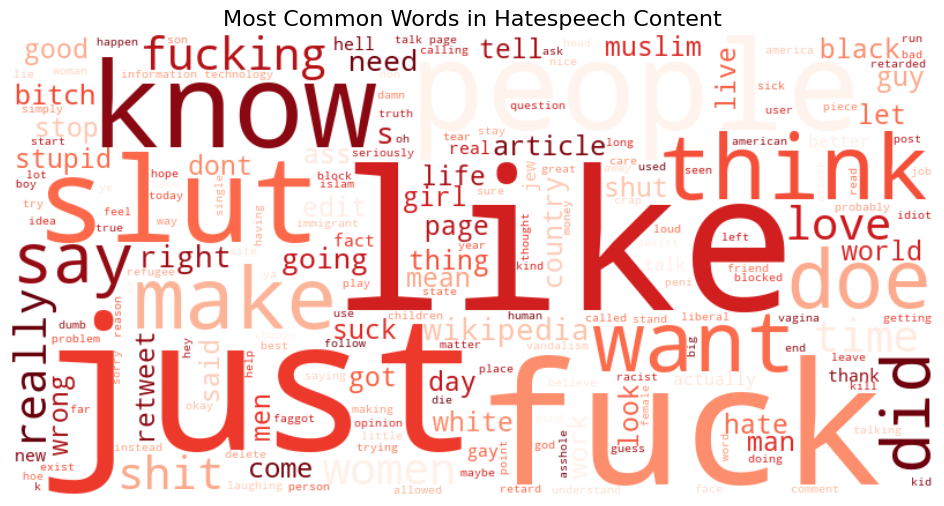

In [ ]:
#Checking for the most common words in the dataset from the content column which are lablled as 1 (hatespeech)
hate_df = df[df['Label'] == 1]

#Combine all content into one string

hate_text = " ".join(hate_df['Content'].tolist())

text = re.sub(r'[^A-Za-z! ]+', '', hate_text)

# Generate WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=ENGLISH_STOP_WORDS,
    colormap='Reds'
).generate(text)

# Show plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Hatespeech Content", fontsize=16)
plt.show()

Selecting the first 30 most commons words from the wordcloud for model training

In [56]:
#Selecting the top 30 most common hatewords in the dataset
hatewords = list(wordcloud.words_.keys())[:30]

len(hatewords)

30

Coding the Multinomial Naive Bayes Model

In [57]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(df['Content'], df['Label'], test_size=0.2, random_state=42, shuffle=True)

# Initialize TF-IDF normally first
tfidf = TfidfVectorizer(ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Get feature names
feature_names = tfidf.get_feature_names_out()

# Find indices of hatewords in feature matrix
hateword_indices = [i for i, word in enumerate(feature_names) if word in hatewords]

# Boost TF-IDF weights of hatewords
boost_factor = 2.0 # You can tune this
X_train_tfidf_boosted = X_train_tfidf.copy()
X_train_tfidf_boosted[:, hateword_indices] *= boost_factor

X_test_tfidf_boosted = X_test_tfidf.copy()
X_test_tfidf_boosted[:, hateword_indices] *= boost_factor

# Train MultinomialNB
clf = MultinomialNB(alpha = 0.1)
clf.fit(X_train_tfidf_boosted, y_train)
y_pred = clf.predict(X_test_tfidf_boosted)

# Results
print(classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     72043
           1       0.83      0.95      0.89     73181

    accuracy                           0.88    145224
   macro avg       0.89      0.88      0.88    145224
weighted avg       0.89      0.88      0.88    145224

Accuracy: 0.8768936263978406


Here, we can see that the model's overall accuracy is 87% using MultinomialNB with TFIDF Vectorizer with custom boostin factor for hatewords.